In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import interp
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

Корректируем датасет:  
1) корректировка используемого в модели значения капитализации и разницы логарифмов между раундами  
2) исключение раундов "без ответа"  
3) приведение дат к нужному формату

In [2]:
dataset = pd.read_csv('model_rounds.csv')

# ritter = pd.read_csv('nasdaq_wtd_mc_ritter_add.csv')
# nasd = pd.read_excel('NASDAQ all v3.xlsx', sheet_name = 3)
unicorns = pd.read_csv('C:/Users/Barca/Dropbox/xls copies/Uni Oct22.csv')

dataset.head(1)

,Organization Name,Announced Date,Money Raised,Pre-Money Valuation,Lead Investors,Funding Type,Org_Code,Round_Code,industry,first_round_date,time_from_start,time_from_previous,investor_rate
0,0x,2021-02-05,14999960.0,NaN,Pantera Capital,Series A,/organization/0x-project,/funding_round/0x-project-series-a--d9b1c1fc,5.0,2021-02-05,0.0,NaN,3


In [3]:
unicorns['Date'] = pd.to_datetime(unicorns['Date'])

df = pd.DataFrame({'new_date': pd.date_range(start = '2009-01-01', end = '2022-10-31', freq = 'D')})
nasd = df.merge(unicorns, how = 'left', left_on = 'new_date', right_on = 'Date')
nasd['Uni'].fillna(method='ffill', inplace=True)
nasd = nasd.drop(['Date'], axis=1)

# nasd['Uni_Deflator_1M'] = nasd['Uni'].shift(30)
# nasd.loc[nasd['Uni_Deflator_1M'].isin([np.nan]), 'Uni_Deflator_1M'] = nasd['Uni']
nasd['Uni_Deflator_3M'] = nasd['Uni'].shift(90)
nasd.loc[nasd['Uni_Deflator_3M'].isin([np.nan]), 'Uni_Deflator_3M'] = nasd['Uni']
# nasd['Uni_Deflator_6M'] = nasd['Uni'].shift(180)
# nasd.loc[nasd['Uni_Deflator_6M'].isin([np.nan]), 'Uni_Deflator_6M'] = nasd['Uni']

nasd

,new_date,Uni,Uni_Deflator_3M
0,2009-01-01,1.000000,1.000000
1,2009-01-02,1.000000,1.000000
2,2009-01-03,1.000000,1.000000
3,2009-01-04,1.000000,1.000000
4,2009-01-05,1.009799,1.009799
...,...,...,...
5047,2022-10-27,4.314722,4.425855
5048,2022-10-28,4.328488,4.425855
5049,2022-10-29,4.328488,4.425855
5050,2022-10-30,4.328488,4.428628


In [4]:
dataset['Announced Date'] = pd.to_datetime(dataset['Announced Date'])
dataset = dataset.merge(nasd, how = 'left', left_on = 'Announced Date', right_on = 'new_date')
dataset = dataset.drop(['Lead Investors', 'new_date', 'Pre-Money Valuation', 'Round_Code', 'first_round_date'], axis=1)

dataset = dataset.loc[~dataset['Money Raised'].isin([np.nan])]
dataset['Money Raised'] = pd.to_numeric(dataset['Money Raised'], errors='coerce')
dataset['Log Money Raised'] = np.log(dataset['Money Raised'])

dataset['total_sum_raised'] = dataset.groupby(['Org_Code'])['Money Raised'].transform('cumsum')
dataset['Log total_sum_raised'] = np.log(dataset['total_sum_raised'])
# dataset['total_sum_raised_before'] = dataset.groupby('Org_Code')['total_sum_raised'].shift(1)
# dataset.loc[dataset['total_sum_raised_before'].isin([np.nan]), 'total_sum_raised_before'] = 0

dataset['time_from_previous'] = pd.to_numeric(dataset['time_from_previous'], errors='coerce')
dataset.loc[dataset['time_from_previous'].isin([np.nan]), 'time_from_previous'] = 0
dataset['time_to_next'] = dataset.groupby('Org_Code')['time_from_previous'].shift(-1)
dataset['Uni_Deflator_3M Target'] = dataset.groupby('Org_Code')['Uni_Deflator_3M'].shift(-1)

dataset['best_investor'] = dataset.groupby(['Org_Code'])['investor_rate'].transform('cummax')
#dataset['previous_investor'] = dataset.groupby('Org_Code')['investor_rate'].shift(1)

dataset['Target Money Raised'] = dataset.groupby('Org_Code')['Money Raised'].shift(-1)
demo_set = dataset.loc[dataset['Target Money Raised'].isin([np.nan])]
dataset = dataset.loc[~dataset['Target Money Raised'].isin([np.nan])]
dataset['Target Log Money Raised'] = np.log(dataset['Target Money Raised'])

dataset

,Organization Name,Announced Date,Money Raised,Funding Type,Org_Code,industry,time_from_start,time_from_previous,investor_rate,Uni,Uni_Deflator_3M,Log Money Raised,total_sum_raised,Log total_sum_raised,time_to_next,Uni_Deflator_3M Target,best_investor,Target Money Raised,Target Log Money Raised
0,0x,2021-02-05,14999960.0,Series A,/organization/0x-project,5.0,0.0,0.0,3,4.911099,4.629882,16.523558,14999960.0,16.523558,445.0,4.712680,3,70000000.0,18.064006
4,10 Federal,2018-10-30,8395000.0,Venture - Series Unknown,/organization/10-federal,2.0,0.0,0.0,0,3.686366,3.807139,15.943147,8395000.0,15.943147,546.0,4.081857,0,24519000.0,17.014959
5,10 Federal,2020-04-28,24519000.0,Venture - Series Unknown,/organization/10-federal,2.0,546.0,546.0,0,4.035382,4.081857,17.014959,32914000.0,17.309409,245.0,4.521296,0,32000000.0,17.281246
7,100 Thieves,2018-10-23,25000000.0,Series A,/organization/100-thieves,3.0,0.0,0.0,1,3.725349,3.952002,17.034386,25000000.0,17.034386,266.0,3.878409,1,35000000.0,17.370859
9,Redox,2015-10-20,3530000.0,Series A,/organization/100health,7.0,0.0,0.0,1,3.344746,3.447982,15.076808,3530000.0,15.076808,448.0,3.437057,1,9000000.0,16.012735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67720,Zynga,2010-06-14,300000000.0,Series B,/organization/zynga,1.0,895.0,51.0,1,1.674593,1.698745,19.519293,370213000.0,19.729589,120.0,1.703390,5,6337786.0,15.662040
67721,Zynga,2010-10-12,6337786.0,Venture - Series Unknown,/organization/zynga,1.0,1015.0,120.0,0,1.872206,1.703390,15.662040,376550786.0,19.746563,129.0,1.932129,5,490000000.0,20.009916
67724,ZYOMYX,2013-06-30,12000000.0,Series B,/organization/zyomyx-inc,8.0,0.0,0.0,1,2.479745,2.261870,16.300417,12000000.0,16.300417,11.0,2.306336,1,14219999.0,16.470160
67726,Zype,2015-10-27,1600000.0,Seed,/organization/zype,3.0,0.0,0.0,1,3.363752,3.427959,14.285514,1600000.0,14.285514,280.0,3.338130,1,2000000.0,14.508658


In [5]:
dataset = dataset.loc[dataset['Announced Date'] >= '2009-01-01']
dataset = dataset.loc[~dataset['industry'].isin([np.nan])]
#dataset.loc[dataset['previous_investor'].isin([np.nan]), 'previous_investor'] = 0
dataset = dataset.loc[~dataset['Uni_Deflator_3M Target'].isin([np.nan])]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33996 entries, 0 to 67727
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Organization Name        33996 non-null  object        
 1   Announced Date           33996 non-null  datetime64[ns]
 2   Money Raised             33996 non-null  float64       
 3   Funding Type             33996 non-null  object        
 4   Org_Code                 33996 non-null  object        
 5   industry                 33996 non-null  float64       
 6   time_from_start          33996 non-null  float64       
 7   time_from_previous       33996 non-null  float64       
 8   investor_rate            33996 non-null  int64         
 9   Uni                      33996 non-null  float64       
 10  Uni_Deflator_3M          33996 non-null  float64       
 11  Log Money Raised         33996 non-null  float64       
 12  total_sum_raised         33996 n

In [6]:
demo_set = demo_set.loc[demo_set['Announced Date'] >= '2020-01-01']
demo_set = demo_set.loc[~demo_set['industry'].isin([np.nan])]
demo_set = demo_set.loc[demo_set['Funding Type'] != 'ipo']
demo_set['Uni_Deflator_3M Target'] = 4.447291
demo_set['Uni_Deflator_3M'] = 4.447291
demo_set['time_to_next'] = pd.Timestamp('2022-12-01') - demo_set['Announced Date']
demo_set['time_to_next'] = demo_set['time_to_next'] / np.timedelta64(1, 'D')
demo_set.to_csv('demo_set.csv', index=False, encoding = 'utf-8-sig')
demo_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6985 entries, 1 to 67700
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Organization Name       6985 non-null   object        
 1   Announced Date          6985 non-null   datetime64[ns]
 2   Money Raised            6985 non-null   float64       
 3   Funding Type            6985 non-null   object        
 4   Org_Code                6985 non-null   object        
 5   industry                6985 non-null   float64       
 6   time_from_start         6985 non-null   float64       
 7   time_from_previous      6985 non-null   float64       
 8   investor_rate           6985 non-null   int64         
 9   Uni                     6949 non-null   float64       
 10  Uni_Deflator_3M         6985 non-null   float64       
 11  Log Money Raised        6985 non-null   float64       
 12  total_sum_raised        6985 non-null   float64

In [9]:
dataset.groupby('Org_Code').size().reset_index(name='count').sort_values(['count'])

,Org_Code,count
0,/organization/0x-project,1
7290,/organization/lumigent,1
7286,/organization/lumenergi,1
7285,/organization/lumena-pharmaceuticals,1
7283,/organization/lumen-bioscience-inc,1
...,...,...
10540,/organization/robinhood,13
1632,/organization/biodesix,14
13008,/organization/uber,14
11604,/organization/space-exploration-technologies,15


In [15]:
table1 = dataset[['Org_Code', 'Organization Name', 'Announced Date', 'Money Raised']]
table1.rename(columns = {'Money Raised' : '1_round'}, inplace = True)
table1['2_round'] = table1.groupby('Org_Code')['1_round'].shift(-1)
table1['3_round'] = table1.groupby('Org_Code')['1_round'].shift(-2)
table1['4_round'] = table1.groupby('Org_Code')['1_round'].shift(-3)
table1['5_round'] = table1.groupby('Org_Code')['1_round'].shift(-4)
table1['6_round'] = table1.groupby('Org_Code')['1_round'].shift(-5)
table1['7_round'] = table1.groupby('Org_Code')['1_round'].shift(-6)
table1['8_round'] = table1.groupby('Org_Code')['1_round'].shift(-7)
table1['9_round'] = table1.groupby('Org_Code')['1_round'].shift(-8)
table1['10_round'] = table1.groupby('Org_Code')['1_round'].shift(-9)
table1['11_round'] = table1.groupby('Org_Code')['1_round'].shift(-10)
table1['12_round'] = table1.groupby('Org_Code')['1_round'].shift(-11)
table1['13_round'] = table1.groupby('Org_Code')['1_round'].shift(-12)
table1['14_round'] = table1.groupby('Org_Code')['1_round'].shift(-13)
table1['15_round'] = table1.groupby('Org_Code')['1_round'].shift(-14)
table1 = table1.loc[table1.groupby(['Org_Code'])['Announced Date'].idxmin()]
table1 = table1.drop(columns=['Announced Date'])
table1.to_csv('tab_rounds.csv', index=False, encoding = 'utf-8-sig')
table1

,Org_Code,Organization Name,1_round,2_round,3_round,4_round,5_round,6_round,7_round,8_round,9_round,10_round,11_round,12_round,13_round,14_round,15_round
0,/organization/0x-project,0x,14999960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/organization/10-federal,10 Federal,8395000.0,24519000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,/organization/100-thieves,100 Thieves,25000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,/organization/100health,Redox,3530000.0,9000000.0,1000000.0,33000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,/organization/100ms,100ms,4500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67707,/organization/zymergen,Zymergen,2000000.0,42140000.0,130000000.0,400000000.0,300000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67713,/organization/zynerba-pharmaceuticals,Zynerba Pharmaceuticals,13000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67718,/organization/zynga,Zynga,15187000.0,15000000.0,300000000.0,6337786.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67724,/organization/zyomyx-inc,ZYOMYX,12000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Матрица корреляций и графики взаимной зависимости между признаками

In [7]:
dataset = dataset.drop(columns=['Organization Name', 'Announced Date', 'Funding Type', 'Org_Code', 'Uni', 'Money Raised', 'total_sum_raised', 'Target Money Raised'])
demo_set = demo_set.drop(columns=['Organization Name', 'Announced Date', 'Funding Type', 'Org_Code', 'Uni', 'Money Raised', 'total_sum_raised', 'Target Money Raised'])
test_tab = dataset.astype('float')
test_tab.corr()

,industry,time_from_start,time_from_previous,investor_rate,Uni_Deflator_3M,Log Money Raised,Log total_sum_raised,time_to_next,Uni_Deflator_3M Target,best_investor,Target Log Money Raised
industry,1.000000,0.071954,0.030234,-0.117694,-0.026030,0.086257,0.118094,-0.002790,-0.027663,-0.084572,0.034714
time_from_start,0.071954,1.000000,0.614124,0.034873,0.007250,0.347153,0.616385,-0.027618,0.001976,0.323724,0.211014
time_from_previous,0.030234,0.614124,1.000000,0.040486,0.001809,0.234722,0.354414,0.024454,0.014429,0.178327,0.108118
investor_rate,-0.117694,0.034873,0.040486,1.000000,0.074386,0.392286,0.282115,-0.017703,0.070567,0.744212,0.324733
Uni_Deflator_3M,-0.026030,0.007250,0.001809,0.074386,1.000000,0.177906,0.105214,-0.160135,0.888983,0.010065,0.256818
Log Money Raised,0.086257,0.347153,0.234722,0.392286,0.177906,1.000000,0.874209,-0.017476,0.174774,0.480207,0.652674
Log total_sum_raised,0.118094,0.616385,0.354414,0.282115,0.105214,0.874209,1.000000,-0.058653,0.090431,0.522572,0.595198
time_to_next,-0.002790,-0.027618,0.024454,-0.017703,-0.160135,-0.017476,-0.058653,1.000000,0.161894,-0.046749,0.062512
Uni_Deflator_3M Target,-0.027663,0.001976,0.014429,0.070567,0.888983,0.174774,0.090431,0.161894,1.000000,-0.001951,0.298882
best_investor,-0.084572,0.323724,0.178327,0.744212,0.010065,0.480207,0.522572,-0.046749,-0.001951,1.000000,0.396967


<AxesSubplot:>

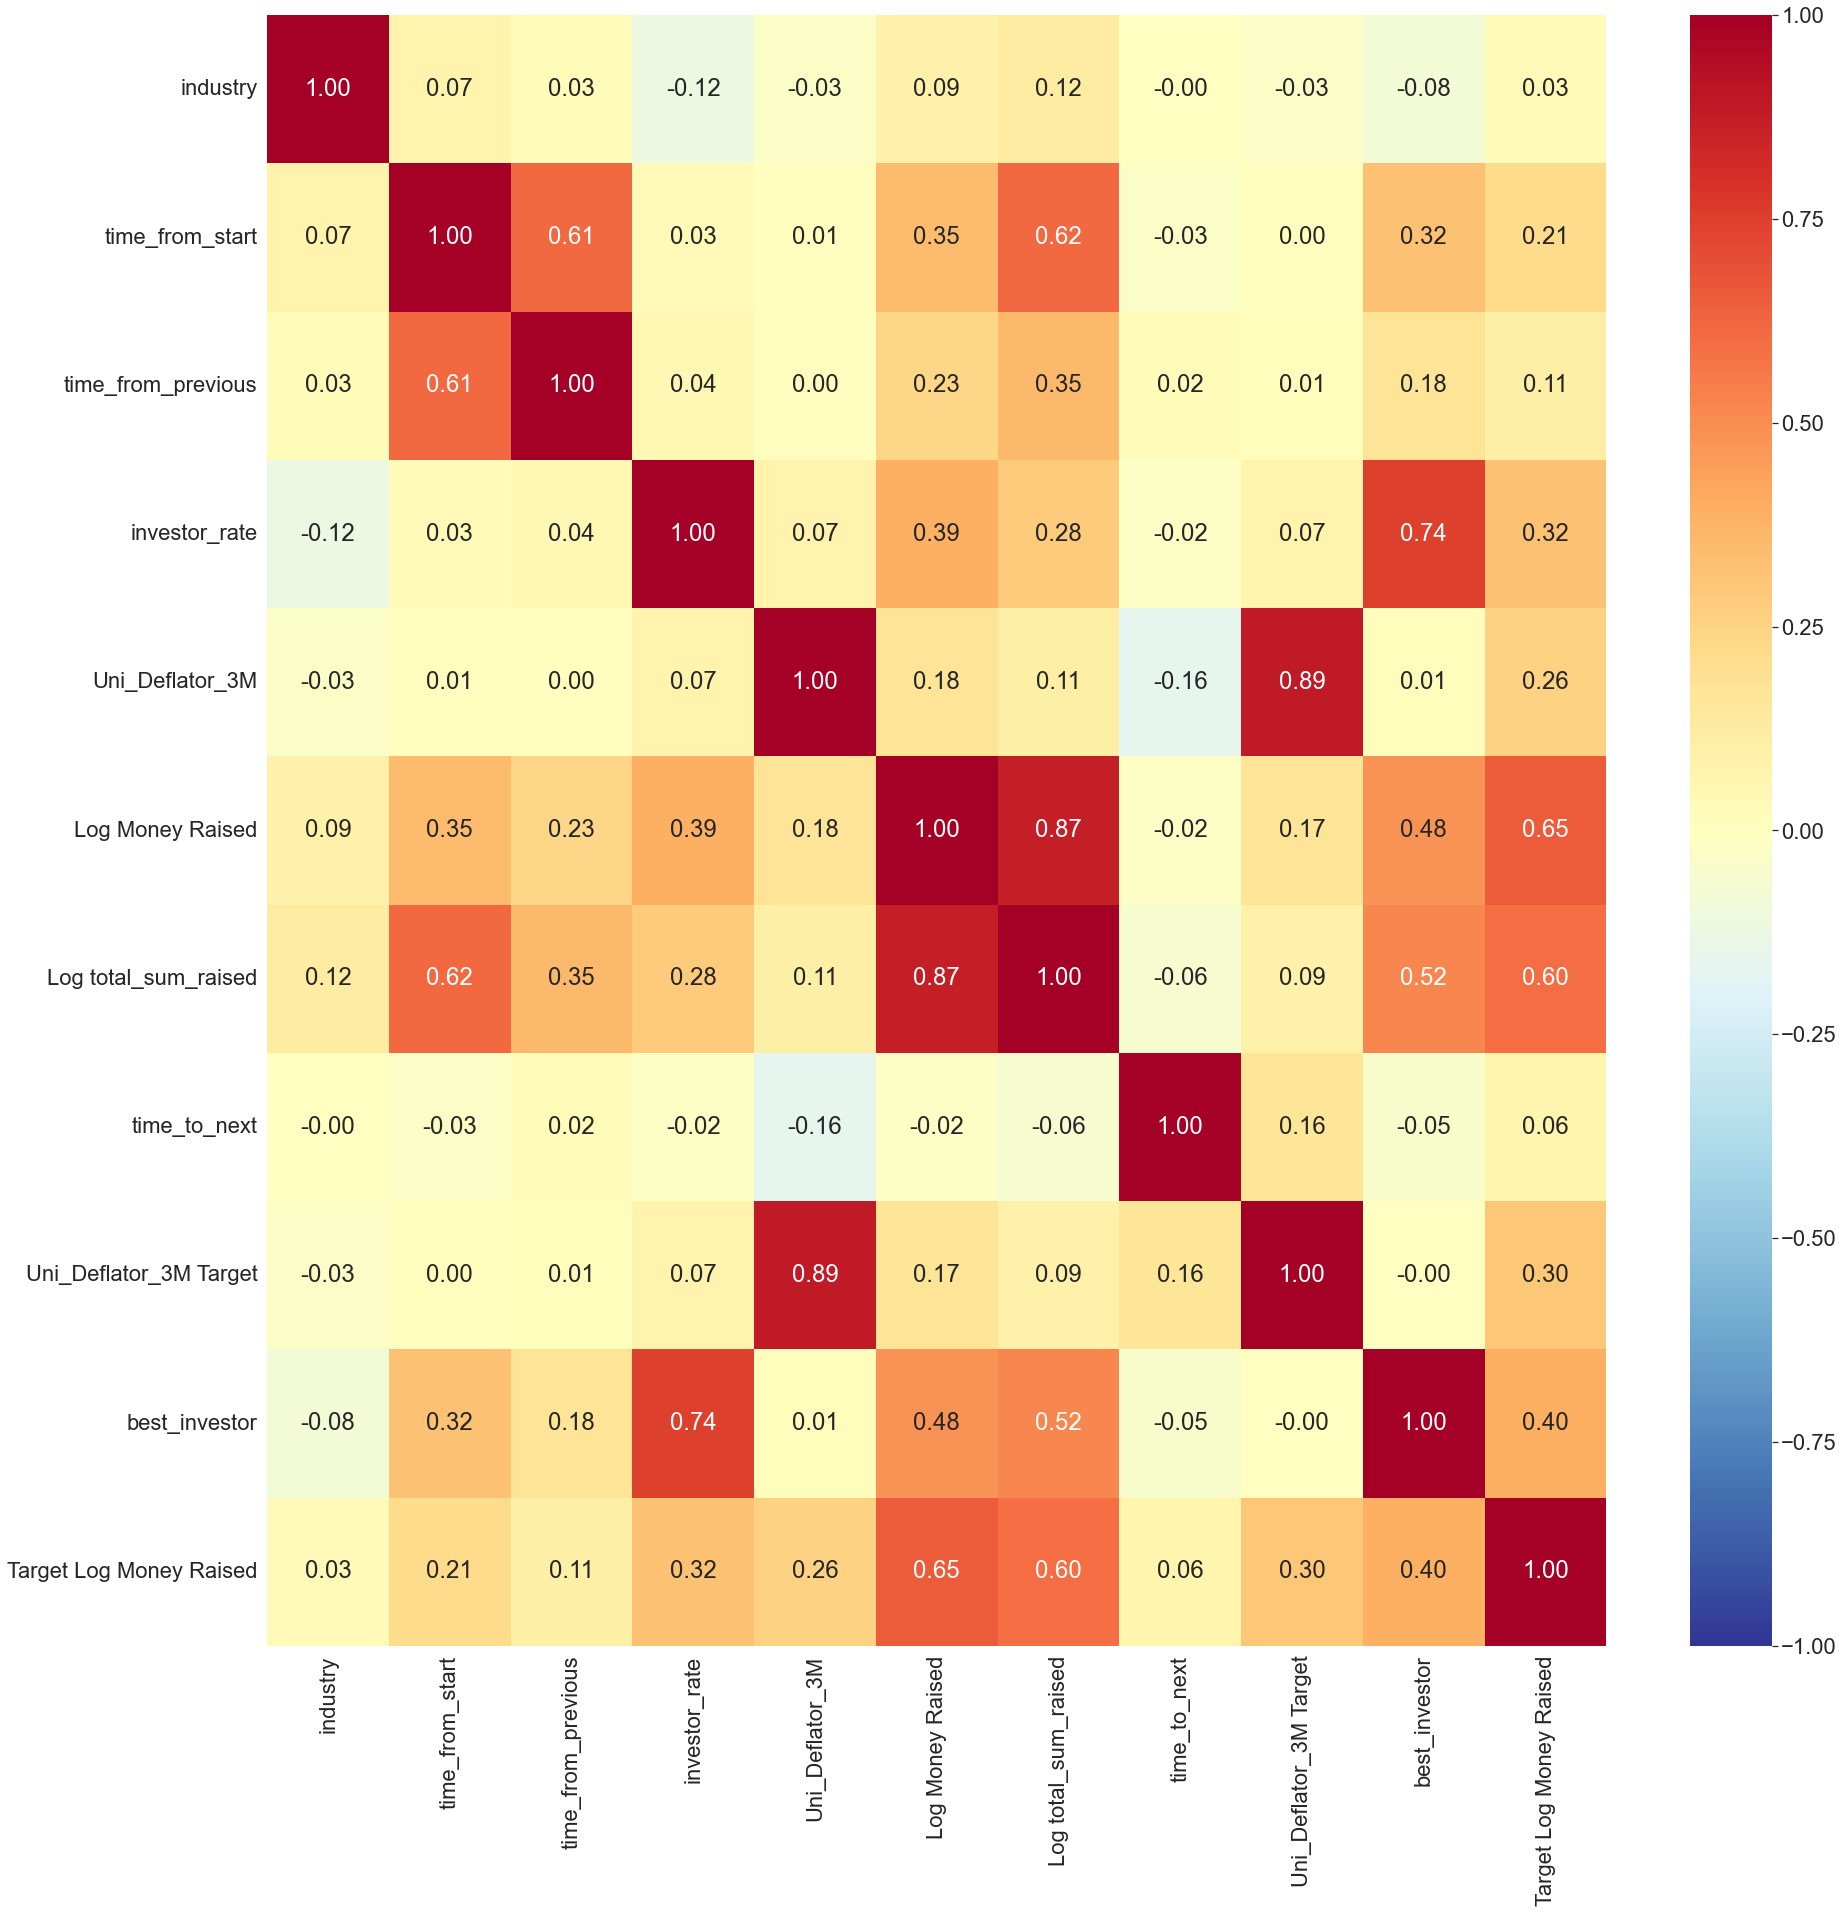

In [8]:
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)
sns.heatmap(test_tab.corr(), annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1, fmt='.2f')
#plt.savefig("heatmap.png")

In [9]:
y = dataset[['Target Log Money Raised']]
y.to_csv('y.csv', index=False, encoding = 'utf-8-sig')
X = dataset.drop(columns=['Target Log Money Raised'])
X.to_csv('X.csv', index=False, encoding = 'utf-8-sig')

demo_set.to_csv('X_demo.csv', index=False, encoding = 'utf-8-sig')

In [10]:
X

,industry,time_from_start,time_from_previous,investor_rate,Uni_Deflator_3M,Log Money Raised,Log total_sum_raised,time_to_next,Uni_Deflator_3M Target,best_investor
0,5.0,0.0,0.0,3,4.629882,16.523558,16.523558,445.0,4.712680,3
4,2.0,0.0,0.0,0,3.807139,15.943147,15.943147,546.0,4.081857,0
5,2.0,546.0,546.0,0,4.081857,17.014959,17.309409,245.0,4.521296,0
7,3.0,0.0,0.0,1,3.952002,17.034386,17.034386,266.0,3.878409,1
9,7.0,0.0,0.0,1,3.447982,15.076808,15.076808,448.0,3.437057,1
...,...,...,...,...,...,...,...,...,...,...
67720,1.0,895.0,51.0,1,1.698745,19.519293,19.729589,120.0,1.703390,5
67721,1.0,1015.0,120.0,0,1.703390,15.662040,19.746563,129.0,1.932129,5
67724,8.0,0.0,0.0,1,2.261870,16.300417,16.300417,11.0,2.306336,1
67726,3.0,0.0,0.0,1,3.427959,14.285514,14.285514,280.0,3.338130,1


In [11]:
y

,Target Log Money Raised
0,18.064006
4,17.014959
5,17.281246
7,17.370859
9,16.012735
...,...
67720,15.662040
67721,20.009916
67724,16.470160
67726,14.508658


In [12]:
demo_set

,industry,time_from_start,time_from_previous,investor_rate,Uni_Deflator_3M,Log Money Raised,Log total_sum_raised,time_to_next,Uni_Deflator_3M Target,best_investor
1,5.0,445.0,445.0,4,4.447291,18.064006,18.258161,219.0,4.447291,4
6,2.0,791.0,245.0,0,4.447291,17.281246,17.988574,702.0,4.447291,0
13,7.0,1954.0,679.0,1,4.447291,17.622173,18.332177,645.0,4.447291,4
15,1.0,156.0,156.0,1,4.447291,16.811243,17.014184,266.0,4.447291,5
20,7.0,1686.0,1012.0,1,4.447291,17.034386,17.466169,626.0,4.447291,1
...,...,...,...,...,...,...,...,...,...,...
67679,1.0,889.0,285.0,0,4.447291,16.300417,17.168218,294.0,4.447291,1
67684,7.0,2163.0,622.0,5,4.447291,19.924758,20.243858,821.0,4.447291,5
67686,4.0,546.0,546.0,3,4.447291,17.312018,17.476505,77.0,4.447291,3
67689,2.0,1626.0,1024.0,4,4.447291,15.843659,16.816230,898.0,4.447291,4
